In [1]:
import numpy as np
from Pipe import Pipe
import pandas as pd
from tobit import *
from utils import *
%matplotlib inline

# 导入csv格式的数据并查看

In [2]:
path = '../data/minidata.csv'
data = read_data(path)
data.head()

,0,index,helpfulness,review_title,total_hours,diff_date,text_content,user_name,game_count,comment_count,xp,review_count,friend_count
0,0,0,81,推荐,0.7,34,20190617更新所谓官方，居然恬不知耻的跑到这里来威胁评测者，不仅不懂法律而且恶意威胁，...,月光疾风,92,4,0,0,0
1,1,1,19,不推荐,11.2,1098,客服的态度仿佛我杀了他妈,さに様,78,0,50,8,10
2,2,2,13,不推荐,41.4,1226,论坛上那是什么狗币客服 天天怼玩家 有你吗这时间还不如多修修你的BUGsteam上面的...,patriceent,2,0,0,1,5
3,3,3,22,推荐,29.4,52,这是一篇带有主观看法的评测。 这是一款出色的海战游戏，也是本世代海战游戏的先驱者和奠基人。 ...,Rhonin_Seiei@上次在线：10天以前,289,1,500,6,46
4,4,4,14,推荐,20.6,26,虽然在出潜艇后我弃坑了，但是不得不说，这是永远永远永远的经典。。。我的童年就是这游戏陪伴我度过的。,方方小次郎,107,0,100,11,32


# 数据预处理，word2vec，lsa提取主题和坐标

In [3]:
# 停用词的地址
stop_words_path = "../dict/baidu_stopwords.txt"
# 自定义词的地址
userdict = "../dict/userdict.txt"
# 删除所有标点符号，数字和特殊字符
pattern = r'[^\u4e00-\u9fa5A-Za-z]'
# word2vec的参数
vec_para = {'token_pattern': r"(?u)\b\w+\b", 'max_features': 1000, 'ngram_range': (1, 1)}
# lsa的参数，n_components为主题数量
lsa_para = {'n_components': 2, 'algorithm': 'randomized', 'n_iter': 100, 'random_state': 122}

In [4]:
pipe = Pipe(stop_words_path, pattern, vec_para, lsa_para, userdict)
token, X_topics, coordinates, terms = pipe.invoke(data["text_content"])

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\cyuuu\AppData\Local\Temp\jieba.cache
Loading model cost 0.593 seconds.
Prefix dict has been built successfully.


In [5]:
# 保存token
save_token_path = "../result/token.txt"
save_token(save_token_path, token)

In [6]:
ouput_topic(terms, pipe.filters[4].svd_model.components_, n=7)

Topic 0: 
游戏 海战 老 玩 经典 玩家 不 
Topic 1: 
经典 产品 获取 免费 老 海战 延续 


# 可视化

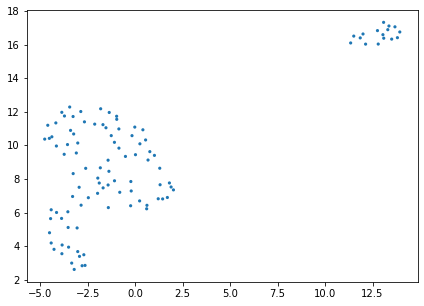

In [7]:
umap_para = {'n_neighbors': 10, 'min_dist': 0.5, 'random_state': 12}
umap_paint(X_topics, umap_para)

# lsa-ENRs处理

In [8]:
vec_enr_para = {'token_pattern': r"(?u)\b\w+\b", 'max_features': 1000, 'ngram_range': (1, 1)}
lsa_enr_para = {'n_components': 2, 'algorithm': 'randomized', 'n_iter': 100, 'random_state': 122}

pipe_enr = Pipe(stop_words_path, pattern, vec_enr_para, lsa_enr_para, userdict)
token_enr, X_topics_enr, coordinates_enr, terms_enr = pipe_enr.invoke(data[data['review_title'] == "不推荐"]["text_content"])

In [9]:
coordinates_enr.shape

(40, 2)

In [10]:
ouput_topic(terms_enr, pipe_enr.filters[4].svd_model.components_, n=7)

Topic 0: 
游戏 还 不 客服 玩 账号 玩家 
Topic 1: 
仿佛 杀 态度 客服 妈 亲妈 傻逼 


# lsa-EPRs处理

In [11]:
vec_epr_para = {'token_pattern': r"(?u)\b\w+\b", 'max_features': 1000, 'ngram_range': (1, 1)}
lsa_epr_para = {'n_components': 2, 'algorithm': 'randomized', 'n_iter': 100, 'random_state': 122}
pipe_epr = Pipe(stop_words_path, pattern, vec_epr_para, lsa_epr_para, userdict)
token_epr, X_topics_epr, coordinates_epr, terms_epr = pipe_epr.invoke(data[data['review_title'] == "推荐"]["text_content"])

In [12]:
coordinates_epr.shape

(66, 2)

In [13]:
ouput_topic(terms_epr, pipe_epr.filters[4].svd_model.components_, n=7)

Topic 0: 
游戏 经典 老 海战 玩 玩家 免费 
Topic 1: 
经典 延续 传世 永远 游戏性 感谢 典型 


# tobit结果

## enr

In [14]:
tr_enr = TobitModel()
x_enr, y_enr, cens_enr = convert_tobit_data(coordinates_enr, data[data['review_title'] == "不推荐"]["helpfulness"])
result_enr = tr_enr.fit(x_enr, y_enr, cens_enr, verbose=False)

In [15]:
result_enr.coef_

array([34.41922092, 12.94886972])

## epr

In [16]:
tr_epr = TobitModel()
x_epr, y_epr, cens_epr = convert_tobit_data(coordinates_epr, data[data['review_title'] == "推荐"]["helpfulness"])
result_epr = tr_epr.fit(x_epr, y_epr, cens_epr, verbose=False)

In [17]:
result_epr.coef_

array([ 39.92214164, -20.06765519])

# classification + regression
对于enr/epr数据，分别先用分类模型将推荐数为0和大于0的数据分开，再对推荐数大于0的数据使用回归模型进行预测